# Stock Picking Strategy

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy import stats
from pandas.tseries.offsets import BDay

### Retrieve Data

In [2]:
close_px = pd.read_csv('spx_member_price.csv', index_col=0, parse_dates=True)
close_px.tail()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-29,153.419998,17.740000,227.270004,160.240005,116.889999,120.230003,319.119995,128.029999,365.820007,687.489990,...,65.589996,233.080002,61.590000,48.689999,123.800003,125.250000,123.500000,607.200012,64.910004,223.550003
2021-11-30,150.899994,17.690001,220.720001,165.300003,115.279999,115.750000,314.779999,125.769997,357.399994,669.849976,...,63.730000,228.449997,59.840000,48.740002,121.110001,122.839996,119.599998,588.780029,63.080002,222.039993
2021-12-01,148.210007,16.280001,218.229996,164.770004,115.910004,114.080002,305.709991,126.739998,360.140015,657.409973,...,64.209999,219.139999,59.790001,48.310001,118.599998,123.220001,119.790001,581.030029,62.369999,219.660004
2021-12-02,150.990005,17.420000,228.759995,163.759995,116.870003,115.800003,312.440002,128.380005,365.299988,671.880005,...,64.650002,218.699997,61.279999,49.430000,120.339996,126.529999,122.930000,596.960022,64.050003,223.190002
2021-12-03,149.330002,16.620001,226.860001,161.839996,118.849998,116.760002,300.630005,130.270004,361.420013,616.530029,...,65.169998,217.059998,60.889999,50.720001,118.089996,124.830002,121.220001,588.289978,61.910000,223.330002


### Define Strategy Parameters

- Rank momentum and volatility based on past lookback period
- Select n stocks based on these ranks
- Equal weight and rebalance monthly

In [3]:
# set parameters
lookback = 9 # lookback period in month to compute momentum
void = 1 # rest period to account for mean-reversion effect

min_assets = 20 # minimum number of stocks to invest in
max_assets = 30 # maximum number of stocks to invest in

q_from = 0.80 # rank quantile to choose from
q_to = 0.90 # rank quantile to choose until

In [4]:
# resample dates to monthly timeframe
month_start = close_px.resample('BMS').mean().index
while [date for date in month_start if date not in close_px.index] != []:
    month_start = [date if date in close_px.index else date+BDay(1) for date in month_start]
    
# capture important dates
start = month_start[:-lookback-void]
rebalance_dates = month_start[lookback+void:]
if void == 0: end = [date-BDay(1) for date in rebalance_dates]
else: end = month_start[lookback:-void]


# check sample of lookback and rebalancing period
i = 200
print(f"Lookback starts : {start[i].date()}")
print(f"Lookback ends   : {end[i].date()}")
print(f"Rebalance on    : {rebalance_dates[i].date()}")

Lookback starts : 2016-08-01
Lookback ends   : 2017-05-01
Rebalance on    : 2017-06-01


In [5]:
# prepare allocation dataframe
allocation = close_px.copy()
allocation.loc[:] = np.nan

# loop over each rebalancing period
for i in range(len(rebalance_dates)):
    
    # define dates for ease of reference
    start_look = start[i]
    end_look = end[i]
    start_rebal = rebalance_dates[i]
    try: end_rebal = rebalance_dates[i+1] - BDay(1)
    except: end_rebal = None    

    # slice dataframe and rank positive momentum
    df = close_px.loc[start_look:end_look].dropna(axis=1, how='any')
    mom = df.iloc[-1] / df.iloc[0] - 1
    mom_rank = mom[mom > 0].rank(method='max')
    
    # rank volatility
    vol_rank = (1 / df.pct_change().std()).rank(method='min')
    
    # combine rank
    total_rank = (mom_rank + vol_rank).dropna()
    
    # select long potential
    n = len(total_rank)
    long_names = total_rank.sort_values().iloc[int(n*q_from) : int(n*q_to)].index.tolist()
    long_rank = total_rank[long_names].values
    
    # long condition
    if len(long_names) >= min_assets:
        
        # make final selection and compute allocation based on inverse volatility
        selected_names = total_rank[long_names].nlargest(max_assets).index.tolist()
        #selected_alloc = total_rank[selected_names] / np.sum(total_rank[selected_names])
        selected_alloc = (vol_rank[selected_names]) / np.sum(vol_rank[selected_names])

        # assign allocation
        allocation.loc[start_rebal:end_rebal, selected_names] = selected_alloc.values

        # log message
        print(f"Lookback starts : {str(start_look.date())}")
        print(f"Lookback ends   : {str(end_look.date())}")
        print(f"Allocate from   : {str(start_rebal.date())}")
        if end_rebal is not None: print(f"Allocate until  : {str(end_rebal.date())}")
        else: print(f"Allocate until  : {str(allocation.index[-1].date())}")
        print(f"Long names ({len(selected_names)}) : {', '.join(selected_names)}")
        print('==========================================')   

Lookback starts : 1999-12-31
Lookback ends   : 2000-09-01
Allocate from   : 2000-10-02
Allocate until  : 2000-10-31
Long names (23) : UHS, WELL, EQR, NI, UNH, NEE, LEN, LUV, VNO, HES, REG, MTB, C, BAX, L, PEAK, O, J, FMC, CAH, PEP, POOL, UDR
Lookback starts : 2000-01-03
Lookback ends   : 2000-10-02
Allocate from   : 2000-11-01
Allocate until  : 2000-11-30
Long names (23) : LUV, PLD, FE, MTB, DRE, PEAK, L, LEN, DTE, UNH, J, MCO, KIM, WRB, CAH, PEP, MGM, NI, AIG, CI, EQR, AEP, GD
Lookback starts : 2000-02-01
Lookback ends   : 2000-11-01
Allocate from   : 2000-12-01
Allocate until  : 2001-01-01
Long names (24) : PNW, EXC, ABT, UNH, EVRG, UHS, SYY, AFL, PEP, AEE, MCO, MTB, LMT, AIG, XRAY, DRE, PHM, DHR, NI, TRV, PLD, EMR, AEP, KIM
Lookback starts : 2000-03-01
Lookback ends   : 2000-12-01
Allocate from   : 2001-01-02
Allocate until  : 2001-01-31
Long names (25) : BXP, NOC, SYY, AVB, CI, AFL, PEG, WRB, MTB, EFX, COP, CAG, BA, ED, LUV, TRV, DHR, RE, EVRG, PHM, FMC, ADP, EQR, SO, HST
Lookback 

Lookback starts : 2003-05-01
Lookback ends   : 2004-02-02
Allocate from   : 2004-03-01
Allocate until  : 2004-03-31
Long names (30) : GD, EXC, WAT, ETR, PNC, PLD, PBCT, AXP, AME, XEL, GL, YUM, ROP, HSIC, HIG, MO, MGM, SJM, TROW, VLO, STT, REG, DHR, ES, ETN, RCL, AVB, GPN, ZBH, MKC
Lookback starts : 2003-06-02
Lookback ends   : 2004-03-01
Allocate from   : 2004-04-01
Allocate until  : 2004-04-30
Long names (30) : SHW, ETN, BXP, SYY, MCO, DHR, HES, PKG, REG, TXT, ZBH, YUM, HSY, KEY, AVB, ITW, ALL, TMO, MO, JCI, NKE, MMM, PBCT, MKC, WFC, EVRG, RCL, HST, MET, CHD
Lookback starts : 2003-07-01
Lookback ends   : 2004-04-01
Allocate from   : 2004-05-03
Allocate until  : 2004-05-31
Long names (30) : DVA, KMB, PRU, HSIC, CCL, MAS, VFC, ALL, SPGI, SYY, PG, PEP, XEL, ETN, TMO, CVX, HSY, ZBH, MET, WAT, BLK, HST, BEN, WLTW, O, AIG, EXC, WM, PBCT, BWA
Lookback starts : 2003-08-01
Lookback ends   : 2004-05-03
Allocate from   : 2004-06-01
Allocate until  : 2004-06-30
Long names (30) : ALL, EVRG, ETN, D

Lookback starts : 2006-08-01
Lookback ends   : 2007-05-01
Allocate from   : 2007-06-01
Allocate until  : 2007-06-29
Long names (30) : DTE, JCI, GPC, KMB, WAT, NRG, VFC, T, SJM, FIS, HPQ, IPG, MTD, EXC, MSFT, PRU, PKI, D, CL, BEN, MMM, DISCA, CE, CDNS, TMO, AIG, OMC, IT, GIS, TRV
Lookback starts : 2006-09-01
Lookback ends   : 2007-06-01
Allocate from   : 2007-07-02
Allocate until  : 2007-07-31
Long names (30) : FMC, CMS, AZO, NRG, FIS, MTD, TRV, PH, CRL, FE, OMC, TSN, AON, LNC, CDNS, CE, BA, PEG, DISCA, UNP, DLTR, RL, T, AIG, AME, AXP, SEE, VZ, ETN, AFL
Lookback starts : 2006-10-02
Lookback ends   : 2007-07-02
Allocate from   : 2007-08-01
Allocate until  : 2007-09-03
Long names (30) : NKE, STE, CE, NEE, AME, T, CB, SYK, MET, ACN, BMY, NRG, DTE, TRV, DISCA, MTD, CMS, ETN, AEP, SJM, EFX, AFL, LNC, PNR, RE, CVX, AVY, RTX, RSG, HAS
Lookback starts : 2006-11-01
Lookback ends   : 2007-08-01
Allocate from   : 2007-09-04
Allocate until  : 2007-09-28
Long names (28) : VFC, MCK, PPL, APD, AME, GE

Lookback starts : 2010-03-01
Lookback ends   : 2010-12-01
Allocate from   : 2011-01-03
Allocate until  : 2011-01-31
Long names (30) : CMS, ROP, T, COO, HAS, AJG, HSY, PM, IFF, ROST, ROL, PPG, AEE, SHW, COP, EXPD, AWK, CB, UNP, LH, QCOM, TSCO, ILMN, CNP, EIX, UPS, GPC, IT, GWW, IBM
Lookback starts : 2010-04-01
Lookback ends   : 2011-01-03
Allocate from   : 2011-02-01
Allocate until  : 2011-02-28
Long names (30) : MCD, COP, ES, GWW, CVX, ROP, TAP, IBM, STZ, TSCO, ED, TXN, CB, PPG, AMT, EXPD, LH, AWK, XEL, MAA, EIX, EVRG, LIN, ABC, DUK, SNA, ILMN, ECL, TT, TGT
Lookback starts : 2010-05-03
Lookback ends   : 2011-02-01
Allocate from   : 2011-03-01
Allocate until  : 2011-03-31
Long names (30) : ZBRA, AWK, SO, ED, IT, SEE, MO, ROL, AAPL, CVX, DVA, ADP, APD, MCK, BDX, ATO, MCHP, DVN, MMC, LH, LIN, ADM, ORCL, ACN, XEL, TRV, FMC, WM, CNP, CAH
Lookback starts : 2010-06-01
Lookback ends   : 2011-03-01
Allocate from   : 2011-04-01
Allocate until  : 2011-04-29
Long names (30) : ACN, ADM, CB, AJG, DV

Lookback starts : 2013-04-01
Lookback ends   : 2014-01-02
Allocate from   : 2014-02-03
Allocate until  : 2014-02-28
Long names (30) : CVS, AON, FITB, MSCI, LIN, DIS, AMP, MDT, EFX, WFC, ICE, AFL, PFG, PH, RTX, ZBH, AXP, LHX, DHR, CMA, TECH, SBUX, EMR, PPG, SYK, OMC, COP, WM, BDX, DOV
Lookback starts : 2013-05-01
Lookback ends   : 2014-02-03
Allocate from   : 2014-03-03
Allocate until  : 2014-03-31
Long names (30) : AZO, ODFL, BDX, JCI, ZBH, PNR, MSCI, DHR, MCK, ORLY, FMC, ROK, TDY, AME, UPS, UNP, QCOM, MDT, AON, FRC, HUM, LIN, ADP, PAYX, HSY, AMP, STZ, BLL, EMR, MA
Lookback starts : 2013-06-03
Lookback ends   : 2014-03-03
Allocate from   : 2014-04-01
Allocate until  : 2014-04-30
Long names (30) : LIN, PNR, SBAC, JCI, ROK, ITW, MAR, FRC, AON, CTSH, SRE, NLSN, PFE, AME, MRK, PPG, ZBH, DHR, VFC, STZ, NEE, NKE, ROL, KMB, UPS, HON, FITB, MSCI, AEE, LYB
Lookback starts : 2013-07-01
Lookback ends   : 2014-04-01
Allocate from   : 2014-05-01
Allocate until  : 2014-05-30
Long names (30) : MRK, S

Lookback starts : 2016-01-04
Lookback ends   : 2016-10-03
Allocate from   : 2016-11-01
Allocate until  : 2016-11-30
Long names (30) : O, NOC, CPRT, AWK, KHC, PNW, FIS, PG, DGX, LMT, NI, POOL, CL, ALL, EXPD, NLSN, TSN, WAT, VZ, BRO, IRM, PLD, TXN, GPC, LIN, MTD, EFX, DHR, BIO, MKTX
Lookback starts : 2016-02-01
Lookback ends   : 2016-11-01
Allocate from   : 2016-12-01
Allocate until  : 2017-01-02
Long names (30) : IBM, EXPD, BDX, ALL, SWK, JNJ, FIS, GD, CTAS, MMM, ISRG, MTD, CNP, SYY, WRB, MA, MCHP, TDY, L, GL, WST, PEP, AOS, NEE, LNT, LIN, PAYX, PH, DTE, KHC
Lookback starts : 2016-03-01
Lookback ends   : 2016-12-01
Allocate from   : 2017-01-03
Allocate until  : 2017-01-31
Long names (30) : INTU, ARE, BA, IBM, VRSK, FIS, PNC, LIN, DFS, AOS, TFC, SWK, BIO, DD, SYY, JBHT, ALL, ROL, ADP, MKTX, MMM, SPGI, ICE, PH, DRE, MTB, MTD, TDY, IP, CDW
Lookback starts : 2016-04-01
Lookback ends   : 2017-01-03
Allocate from   : 2017-02-01
Allocate until  : 2017-02-28
Long names (30) : TFC, AFL, DRE, DHR

Lookback starts : 2019-05-01
Lookback ends   : 2020-02-03
Allocate from   : 2020-03-02
Allocate until  : 2020-03-31
Long names (30) : LDOS, ATO, NEM, ALL, NDAQ, EQIX, WLTW, SPGI, TDY, ALLE, PG, WRB, ZTS, WM, HRL, FIS, AEE, VRSK, HIG, V, DRE, ARE, CBOE, T, DGX, PEP, RE, WMT, MCO, D
Lookback starts : 2019-06-03
Lookback ends   : 2020-03-02
Allocate from   : 2020-04-01
Allocate until  : 2020-04-30
Long names (30) : MSFT, GPN, PG, RSG, CTXS, KO, CMS, J, FISV, DG, GOOGL, MDT, MMC, CPRT, AEP, DRE, LMT, SRE, ALL, V, LH, HSY, GOOG, SHW, ROST, NEM, ALLE, PEP, D, GL
Lookback starts : 2019-09-03
Lookback ends   : 2020-06-01
Allocate from   : 2020-07-01
Allocate until  : 2020-07-31
Long names (24) : GOOG, JKHY, HRL, JNJ, CPB, AAPL, TMO, GOOGL, NFLX, AKAM, EBAY, ODFL, TMUS, TSCO, NEM, GILD, WMT, SNPS, FB, CERN, MSFT, PCAR, DVA, CAG
Lookback starts : 2019-10-01
Lookback ends   : 2020-07-01
Allocate from   : 2020-08-03
Allocate until  : 2020-08-31
Long names (22) : AMGN, MNST, JKHY, LLY, TMO, AAPL, G

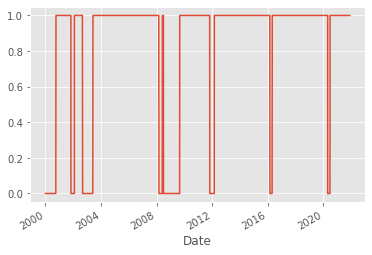

In [6]:
allocation.sum(axis=1).plot(); plt.show() # check portfolio allocation

### Backtest Strategy

In [7]:
# functionalize Sharpe ratio
def sharpe(daily_return):
    return daily_return.mean() / daily_return.std() * np.sqrt(250)

# functionalize maximum drawdown
def max_dd(daily_return):
    roll_max = (daily_return + 1).cumprod().expanding().max()
    daily_dd = (daily_return + 1).cumprod() / roll_max.values - 1.0
    max_dd = daily_dd.abs().max() * 100
    return max_dd

# functionalize annualized return
def annualized_return(daily_return):
    cum_return = (daily_return + 1).cumprod().dropna()
    ann_return = (cum_return.iloc[-1] / cum_return.iloc[0]) ** (1 / len(cum_return) * 252) - 1
    ann_return = ann_return * 100
    return ann_return

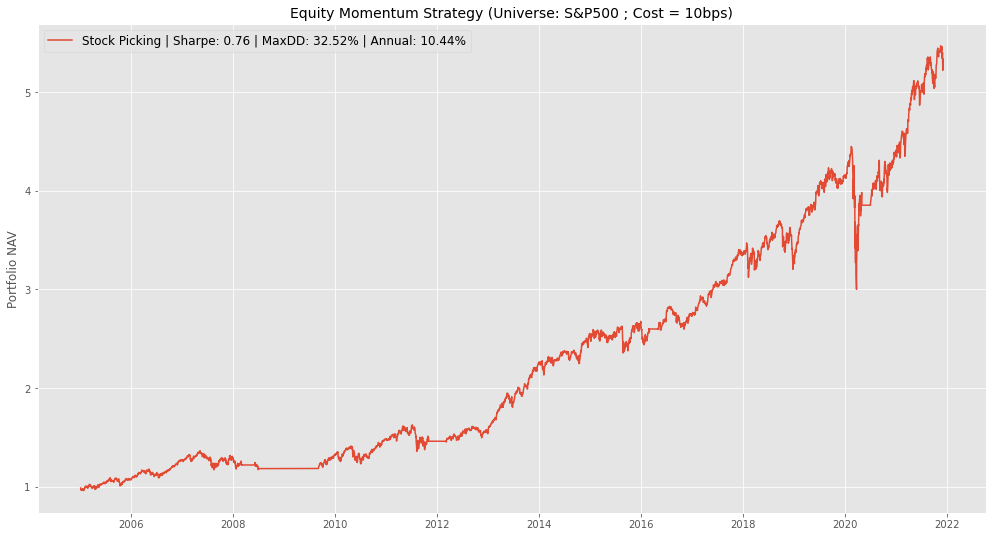

In [8]:
# set trading cost (in bps)
tc = 10
start_test = '2005'
end_test = None

# calculate daily portfolio return
strat = (close_px.pct_change() * allocation.shift()).sum(axis=1).loc[start_test:end_test]

# deduct transaction cost
cost = tc / 10000
turnover = allocation.diff().fillna(0).abs()
strat = strat - (turnover * cost).sum(axis=1)

# plot PnL
plt.figure(figsize=(17,9))
plt.plot((strat + 1).cumprod(), label=f"Stock Picking | Sharpe: {sharpe(strat):.2f} | MaxDD: {max_dd(strat):.2f}% | Annual: {annualized_return(strat):.2f}%")
plt.title(f'Equity Momentum Strategy (Universe: S&P500 ; Cost = {tc}bps)', fontsize=14)
plt.ylabel('Portfolio NAV', fontsize=12)
plt.legend(fontsize=12)
plt.show()

# save
strat.to_csv('stock_pick_return.csv')

### Allocation Statistics

In [9]:
allocation.loc[rebalance_dates[-1]].dropna().sort_values(ascending=False).apply(lambda x: np.round(x*100,2))

HSY      4.81
MCD      4.78
ROP      4.71
ICE      4.64
ARE      4.56
YUM      4.41
CSCO     4.34
A        4.02
WRB      4.01
ROK      3.92
XYL      3.57
TGT      3.32
GPC      3.26
WST      3.14
AVY      3.10
EW       3.02
AON      2.88
RJF      2.85
BK       2.78
GOOGL    2.74
AAP      2.73
ANTM     2.68
GS       2.63
ORCL     2.51
CBRE     2.51
BAC      2.50
LKQ      2.44
MS       2.43
INTU     2.37
CRL      2.35
Name: 2021-12-01 00:00:00, dtype: float64

## The End